In [441]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from scipy.optimize import nnls, minimize
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


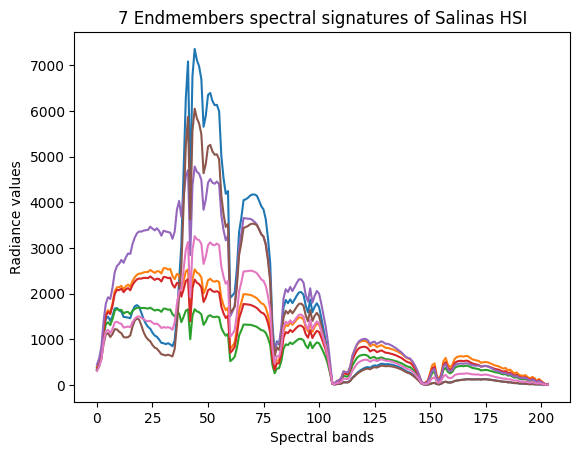

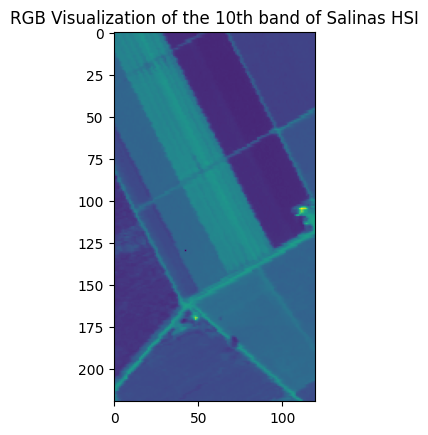

In [442]:
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

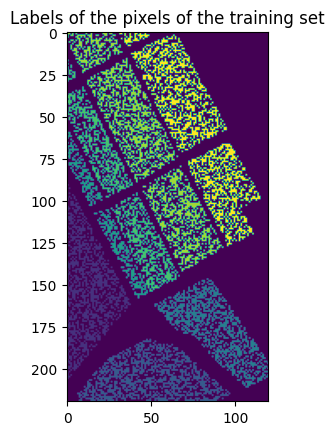

In [443]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

In [444]:
# Least Squares estimate with no constraints
def least_squares(X, y):
    theta, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
    return theta

In [445]:
# Least Squares estimate with sum-to-one constraint
def least_squares_sum_to_one(X, y):
    n = X.shape[1]
    
    # Objective function: ||X*theta - y||^2
    def objective(theta):
        return np.sum((X @ theta - y) ** 2)
    
    # Initial guess
    theta0 = np.ones(n) / n
    
    # Constraint: sum of coefficients = 1
    constraint = {'type': 'eq', 'fun': lambda theta: np.sum(theta) - 1}
    
    result = minimize(objective, theta0, constraints=[constraint], method='SLSQP')
    return result.x

In [446]:
#  Least Squares estimate with non-negativity constraint
def least_squares_nonneg(X, y):
    theta, residuals = nnls(X, y)
    return theta

In [447]:
# Least Squares estimate with non-negativity and sum-to-one constraints
def least_squares_nonneg_sum_to_one(X, y):
    n = X.shape[1]
    
    # Objective function: ||X*theta - y||^2
    def objective(theta):
        return np.sum((X @ theta - y) ** 2)
    
    # Initial guess (uniform positive summing to 1)
    theta0 = np.ones(n) / n
    
    # Bounds: all parameters >= 0
    bounds = [(0, None) for _ in range(n)]
    
    # Constraint: sum of coefficients = 1
    constraint = {'type': 'eq', 'fun': lambda theta: np.sum(theta) - 1}
    
    result = minimize(objective, theta0, bounds=bounds, constraints=[constraint], method='SLSQP')
    return result.x

In [448]:
# Lasso estimate
def lasso(X, y):
    model = Lasso(alpha=0.01, tol=1e-2, positive=True)
    model.fit(X, y)
    coeffs = model.coef_
    
    # Handle the zero-sum case
    if np.sum(coeffs) == 0:
        return np.zeros_like(coeffs)
    
    # Normalize to sum to one
    return coeffs / np.sum(coeffs)

In [449]:
# Unmixing function
def unmix_matrix(endmembers, HSI, labels, method="Least Squares"):
    height, width = labels.shape
    X = endmembers
    n_endmembers = endmembers.shape[1]
    total_error = 0
    pixel_count = 0
    # Initialize the 
    abundance_map = np.zeros((height,width,n_endmembers))

    # Iterate all pixels in the image
    for i in range(height):
        for j in range(width):
            if labels[i,j] != 0:
                y = HSI[i,j,:]

                if method == "Least Squares":
                    theta = least_squares(X, y)
                elif method == "Least Squares Sum-to-One":
                    theta = least_squares_sum_to_one(X, y)
                elif method == "Least Squares Non-Negative":
                    theta = least_squares_nonneg(X, y)
                elif method == "Least Squares Non-Negative Sum-to-One":
                    theta = least_squares_nonneg_sum_to_one(X, y)
                elif method == "Lasso":
                    theta = lasso(X, y)
                else:
                    raise ValueError("Invalid method")
            
                abundance_map[i,j,:] = theta

                reconstructed = X @ theta
                error = np.sum((y - reconstructed)**2)
                total_error += error
                pixel_count += 1

    # Calculate average error
    avg_error = total_error / pixel_count if pixel_count > 0 else 0

    return abundance_map, avg_error

In [454]:
# Plot the results of the unmixing
def plot_abundance_map(abundance_map,  materials):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    # Flatten axes for easier indexing
    axes = axes.ravel()

    # Plot the theta values for each material
    for i in range(7):
        im = axes[i].imshow(abundance_map[:, :, i])
        axes[i].set_title(f'{materials[i+1]}')
        plt.colorbar(im, ax=axes[i])  

    # Plot the sum of the theta values
    axes[7].hist(np.sum(abundance_map.reshape(
        abundance_map.shape[0] * abundance_map.shape[1], abundance_map.shape[2]), axis=1),
        density=True, 
        bins=30)
    
    axes[7].set_title('$\sum_1^7 \\theta_i$')
    axes[8].axis('off')
    
    # # Plot the ground truth labels 
    # im = axes[8].imshow(Training_Set)
    # axes[8].set_title('Label Map (Ground Truth)')
    # cbar = plt.colorbar(im, ticks=np.arange(1, len(materials) + 1))
    # cbar.set_label("Cluster")
    # cbar.set_ticklabels(materials)
    
    plt.show()

In [459]:
# Map of materials
materials = {
    1: 'Grapes',
    2: 'Broccoli',
    3: 'Fallow 1',
    4: 'Fallow 2',
    5: 'Fallow 3',
    6: 'Stubble',
    7: 'Celery'
}
errors_df = pd.DataFrame()
abundance_maps = {}

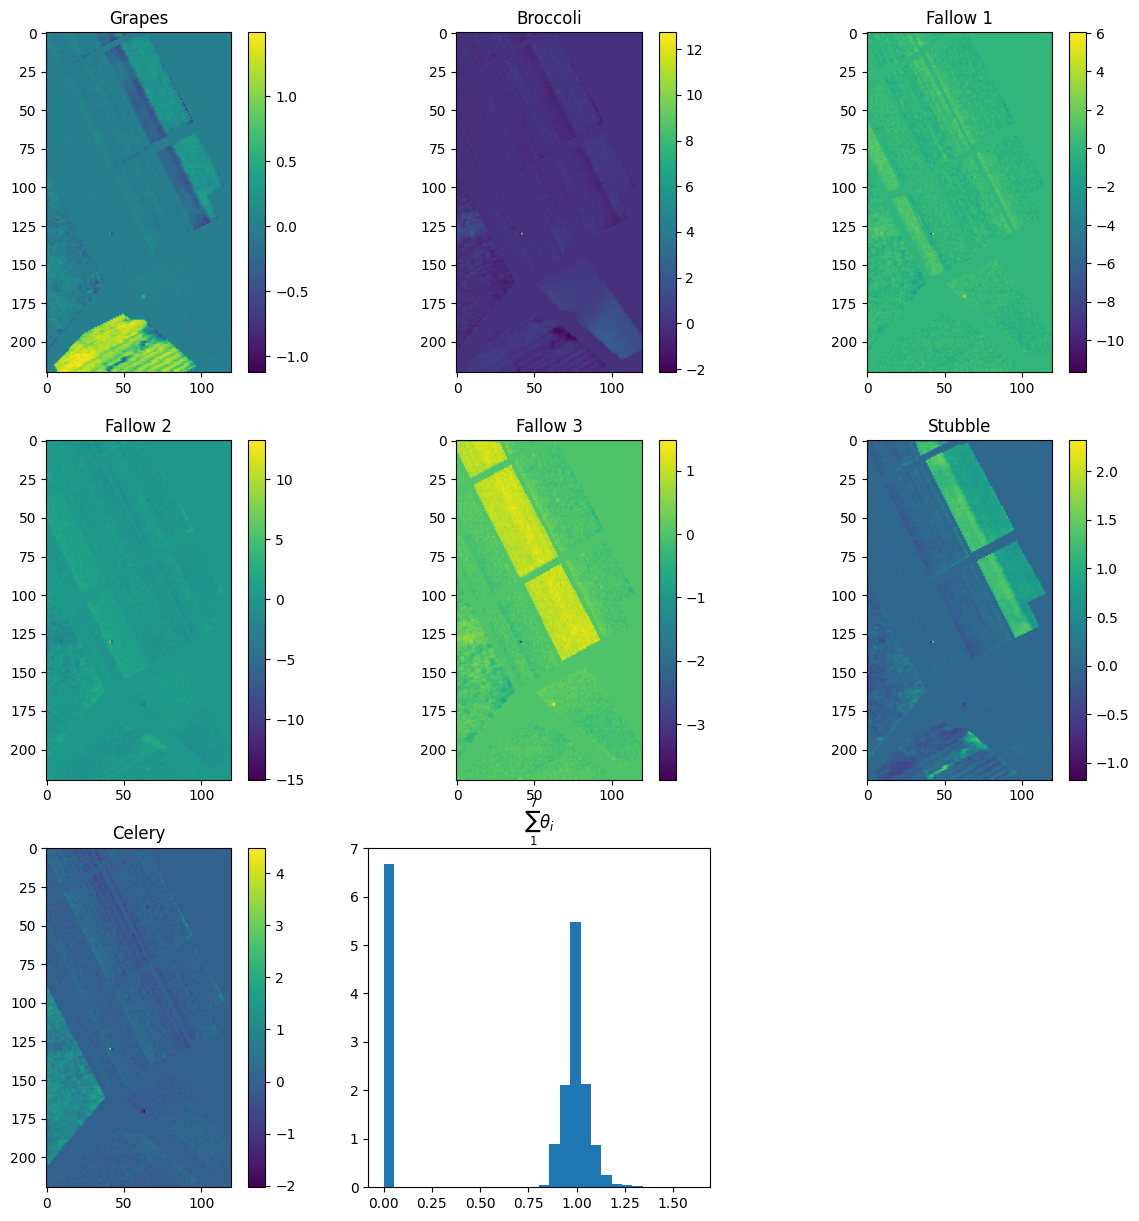

Average reconstruction error:  35058.880662772615


In [460]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels)
plot_abundance_map(abundance_map, materials)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Least Square'] = round(reconstruction_error, 2)
abundance_maps['Least Squares'] = abundance_map

We can observe that by using the `Least Squares with no constraints` we can see both negative values and sums far from 1. While it might achieve good mathematical fits in some regions, the results lack physical meaning and have the highest reconstruction error, making this method impractical for out application. 

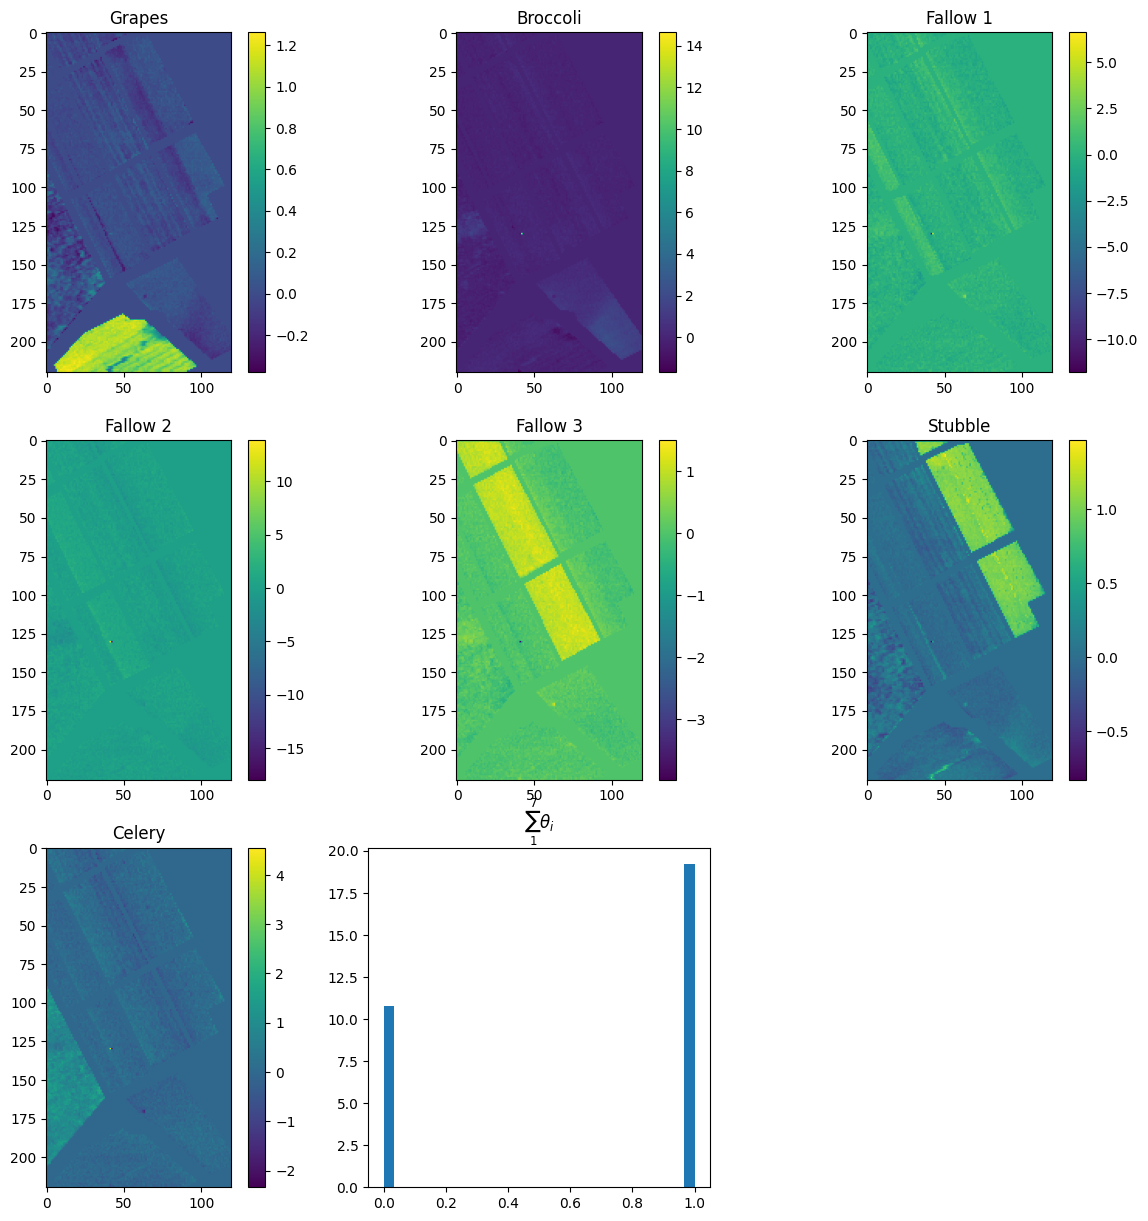

Average reconstruction error:  43082.57630023894


In [461]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Least Squares Sum-to-One")
plot_abundance_map(abundance_map, materials)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Sum-to-One'] = round(reconstruction_error, 2)
abundance_maps['Sum-to-One'] = abundance_map

The results from the `Least Squares Sum-to-One only` reveal the importance of the non-negativity constraint, as it shows significant negative values (blue regions) despite maintaining sum-to-one. The high reconstruction error and physically impossible negative abundances make this method less suitable despite its mathematical validity.

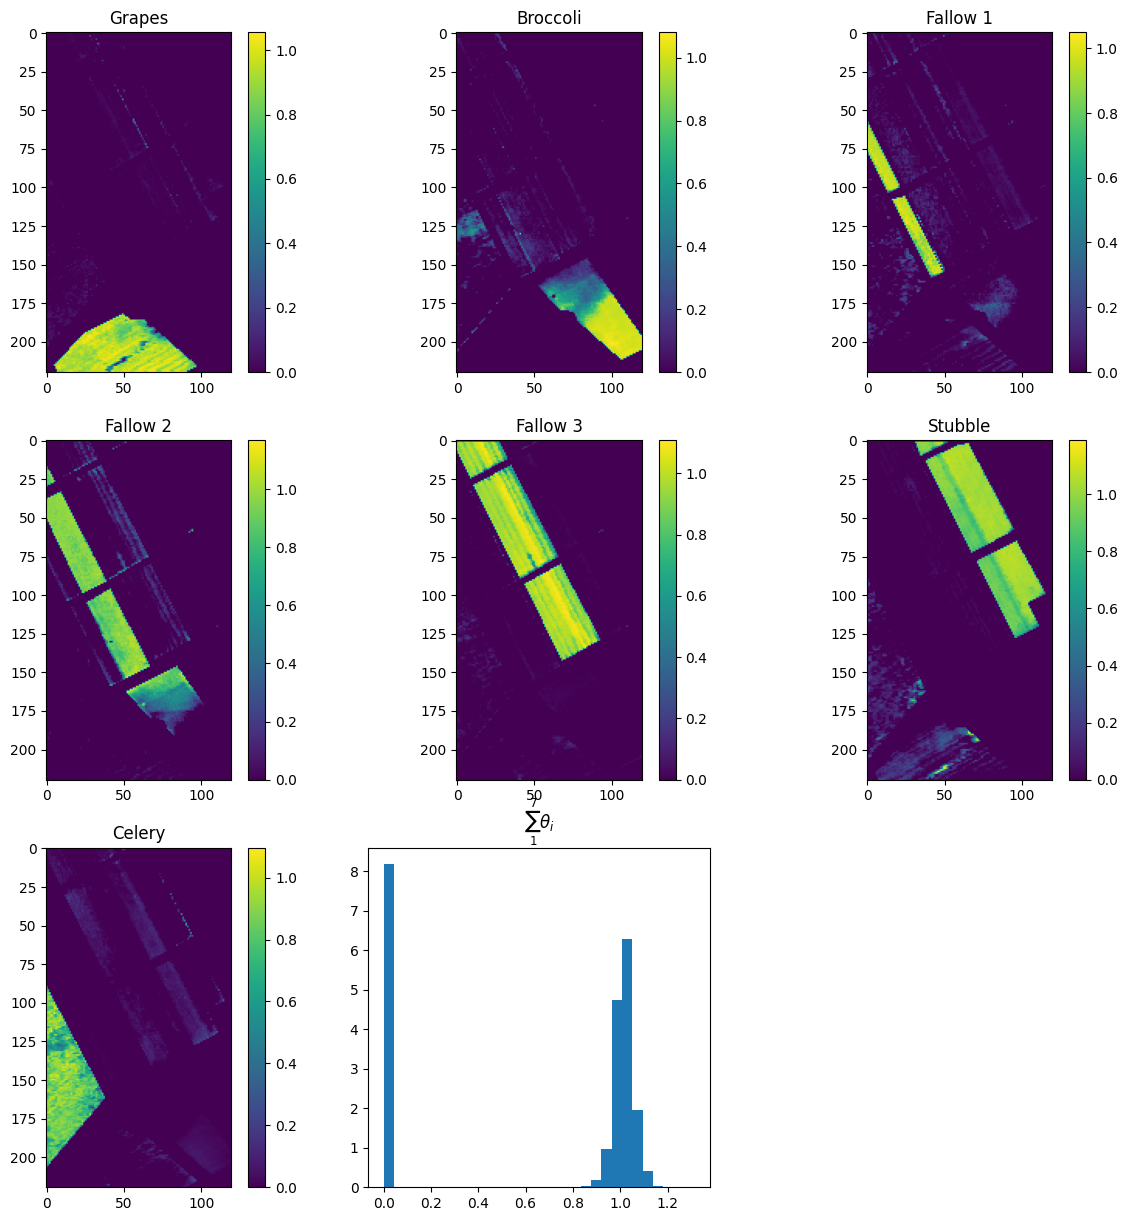

Average reconstruction error:  156104.1822064472


In [468]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Least Squares Non-Negative")
plot_abundance_map(abundance_map, materials)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Non-Negative'] = round(reconstruction_error, 2)
abundance_maps['Non-Negative'] = abundance_map

The results from the `Least Squares Non-negativity only`, show significant overlap between materials and some regions have abundance sums much higher than 1. While it maintains the important physical constraint of non-negative abundances, the lack of sum-to-one constraint leads to less interpretable results in terms of total material composition.

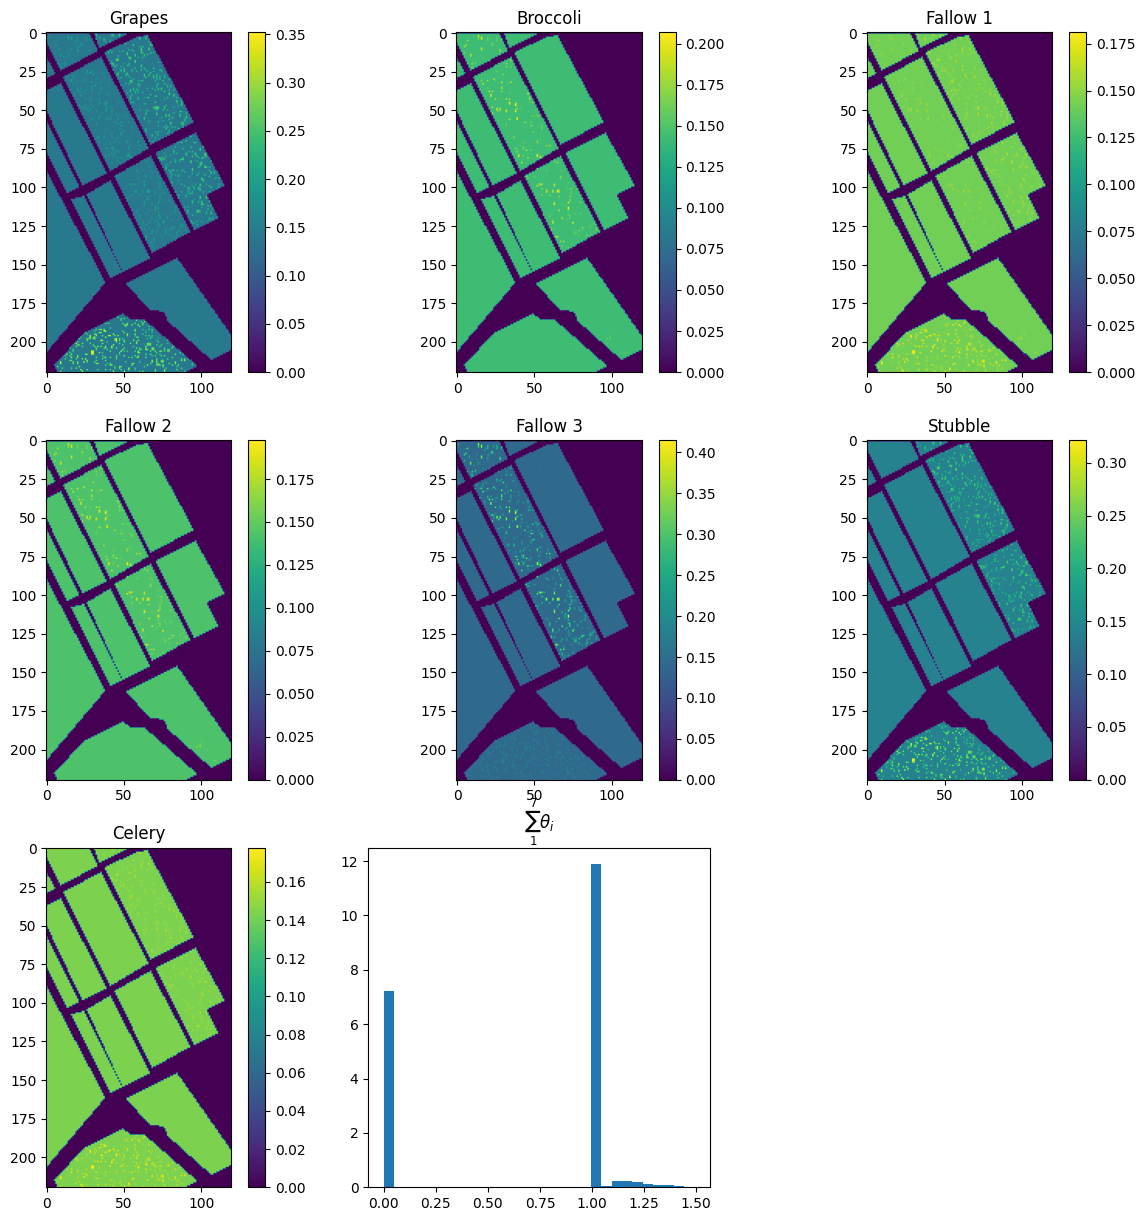

Average reconstruction error:  83294010.38232562


In [466]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Least Squares Non-Negative Sum-to-One")
plot_abundance_map(abundance_map, materials)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Non-Negative Sum-to-One'] = round(reconstruction_error, 2)
abundance_maps['Non-Negative Sum-to-One'] = abundance_map

The results from the `Least Squares fully constrained` deomnstrate more mixed regions between materials, but maintain physical interpretability due to both non-negativity and sum-to-one constraints. While it has higher error, the abundance distributions appear more natural and show realistic transitions between different crop regions.

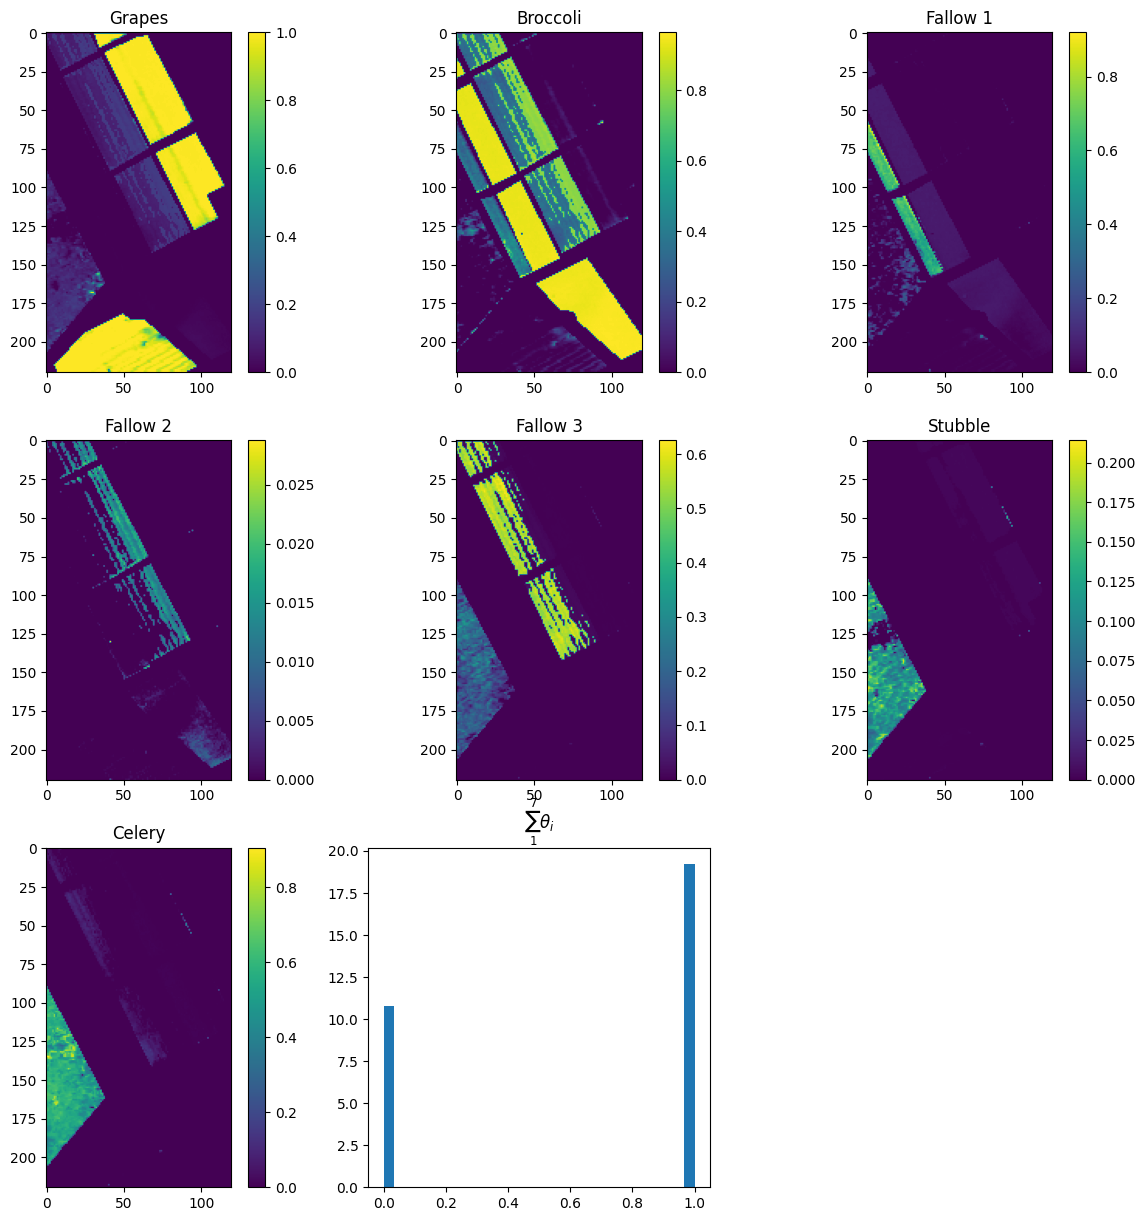

Average reconstruction error:  23039261.771457978


In [467]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Lasso")
plot_abundance_map(abundance_map, materials)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Lasso'] = reconstruction_error
abundance_maps['Lasso'] = abundance_map

The results from the `Lasso Regression` show the most distinct separation between crop types with clean, sparce regions for each material. The abundance maps are highly interpretable, matching well with the ground truth. The **Sum of theta values** staying close to one indicates good physical meaning. Having the lowest reconstruction error while maintaining sparsity makes this method particularly effective for this application.

In [336]:
errors_df

,Least Square,Sum-to-One,Non-Negative,Non-Negative Sum-to-One,Lasso
0,35058.88,43082.58,156104.18,83294010.38,2.303926e+07


In [ ]:
# Plot all the abundance maps next to each other one for each method
def plot_abundance_map(abundance_map,  materials):
    fig, axes = plt.subplots(6, 7, figsize=(16, 16), facecolor='w', edgecolor='k', sharex='col', sharey='row')
    fig.subplots_adjust(hspace=.3, wspace=.001)

    # Flatten axes for easier indexing
    axes = axes.ravel()

    # Plot the theta values for each material
    for i in range(7):
        im = axes[i*5+j].imshow(abundance_map[j, :, :, i])
        axes[i*5+j].set_title(f'{materials[i+1]}')
        plt.colorbar(im, ax=axes[i*5+j])
        # im = axes[i].imshow(abundance_map[:, :, i])
        axes[i].set_title(f'{materials[i+1]}')
        plt.colorbar(im, ax=axes[i])  
    
    plt.show()

The `Average reconstruction errors` follow a clear pattern reflecting the impact of constraints.
  * The **Least squares method** achieves the lowest error but lacks physical constraints. 
  * Enforcing **sum-to-one** slightly increases error, while adding only **non-negativity** leads to a much higher error, due to reduced flexibility.
  * The combination of **sum-to-one and non-negativity** results in a drastic error rise, dute to over restricting the solution space.
  * LASSO enforces sparsity but yields a significantly higher error, suggesting that while constraints guide solutions toward physical plausibility, excessive restriction can negatively impact reconstruction accuracy.

In [351]:
def prepare_data(set, salinas_cube):
  # Keep only the important labels
  set_mask = set != 0

  # Get class labels
  y =  set[set_mask]

  # Get spectral signatures for each labeled pixel
  X_reshaped = salinas_cube.reshape(salinas_cube.shape[0] * salinas_cube.shape[1], salinas_cube.shape[2])
  X = X_reshaped[set_mask.flatten()]

  return X, y


In [352]:
class MinimumDistanceClassifier:
  def __init__(self):
    self.centroids = None
    self.classes = None

  def get_params(self, deep=True):
    return {}
  
  def set_params(self, **parameters):
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self

  def fit(self, X, y):
    self.classes = np.unique(y)
    self.centroids = np.array(
      [X[y == c].mean(axis=0) 
       for c in self.classes])
    
  def predict(self, X):
    distances = np.sqrt(((X[:, np.newaxis, :] - self.centroids) ** 2).sum(axis=2))
    return self.classes[np.argmin(distances, axis=1)]
  
  def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)
  

In [353]:
# Method that performs 10-fold cross-validation
def evaluate_with_cross_validation(clf, X_train, y_train):
    cv_errors = 1 - cross_val_score(clf, X_train, y_train, cv=10)

    mean_valid_error = cv_errors.mean()
    standard_deviation = cv_errors.std()

    return mean_valid_error, standard_deviation

In [354]:
# Method that evaluates the classifier on the test set
def evaluate_on_test_set(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    conf_matrix_array = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(
        conf_matrix_array, 
        columns=[materials.get(i) for i in range(1, 8)], 
        index=[materials.get(i) for i in range(1, 8)])
        
    success_rate = np.trace(conf_matrix) / np.sum(conf_matrix.values)    
    
    # Identify poorly separated classes using DataFrame operations
    poor_separation = []
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            if i != j and conf_matrix.iloc[i, j] > 1:  # Use `.iloc` for DataFrame access
                poor_separation.append((conf_matrix.index[i], conf_matrix.columns[j], conf_matrix.iloc[i, j]))
    
    return conf_matrix, success_rate, poor_separation

In [ ]:
# This method will evaluate a classifier given using cross-validation and on the test set
def produce_classification_results(clf, X_train, y_train, X_test, y_test):
    best_success_rate = 0

    # 1. Cross-validation
    mean_valid_error, standard_deviation = evaluate_with_cross_validation(clf, X_train, y_train)

    # 2. Test set evaluation
    conf_matrix, success_rate, poor_separation = evaluate_on_test_set(clf, X_train, X_test, y_train, y_test)

    # Track best classifier
    if success_rate > best_success_rate:
        best_success_rate = success_rate

    return mean_valid_error, standard_deviation, conf_matrix, success_rate, poor_separation


In [ ]:
classifiers = {
    'min_distance': MinimumDistanceClassifier(),
    'naive_bayes': GaussianNB(),
    'k_nearest': KNeighborsClassifier(n_neighbors=5),
    'bayesian': QuadraticDiscriminantAnalysis()
}

X_train, y_train = prepare_data(Training_Set, HSI)
X_test, y_test = prepare_data(Test_Set, HSI)

results = pd.DataFrame(columns=['Classifier', 'Mean validation error', 'Standard deviation', 'Success rate'])

In [357]:
mean_valid_error, standard_deviation, conf_matrix, success_rate, poor_separation = produce_classification_results(
      classifiers.get('min_distance'), 
      X_train, 
      y_train, 
      X_test, 
      y_test)

print(conf_matrix)

if poor_separation:
        print("\nPoorly separated classes:")
        for true_class, pred_class, count in poor_separation:
            print(f"Class {true_class} confused with Class {pred_class} ({count} pixels)")

results.loc[0] = ['Minimum distance', mean_valid_error, standard_deviation, success_rate]

          Grapes  Broccoli  Fallow 1  Fallow 2  Fallow 3  Stubble  Celery
Grapes       536         0         4         0         1        0       7
Broccoli       2       484         0         0         0        0      31
Fallow 1       0         0       417         0        95        0       0
Fallow 2       0         0         0       212         2        0       0
Fallow 3       0         0        16         4       543        0       0
Stubble        0         0         6         0         0      992       0
Celery         5         0         0         0         0        0     875

Poorly separated classes:
Class Grapes confused with Class Fallow 1 (4 pixels)
Class Grapes confused with Class Celery (7 pixels)
Class Broccoli confused with Class Grapes (2 pixels)
Class Broccoli confused with Class Celery (31 pixels)
Class Fallow 1 confused with Class Fallow 3 (95 pixels)
Class Fallow 2 confused with Class Fallow 3 (2 pixels)
Class Fallow 3 confused with Class Fallow 1 (16 pixels)
Cla

The `Minimum Distance Classifier` works by assigning a pixel to the class with the nearest ceontroid using Euclidean distance. Its performance shows:
  * Major confusion between Broccoli and Fallow 2 (95 pixels); this suggests these classes have similar spectral signatures with centroids relatively close to each other.
  * Notable confusion between Grapes and Stubble (31 pixels); these materials likely have overlapping spectral characteristics.

In [358]:
mean_valid_error, standard_deviation, conf_matrix, success_rate, poor_separation = produce_classification_results(
      classifiers.get('naive_bayes'), 
      X_train, 
      y_train, 
      X_test, 
      y_test)

print(conf_matrix)
    
if poor_separation:
        print("\nPoorly separated classes:")
        for true_class, pred_class, count in poor_separation:
            print(f"Class {true_class} confused with Class {pred_class} ({count} pixels)")

results.loc[1] = ['Naive Bayes', mean_valid_error, standard_deviation, success_rate]

          Grapes  Broccoli  Fallow 1  Fallow 2  Fallow 3  Stubble  Celery
Grapes       545         0         0         0         0        0       3
Broccoli       5       512         0         0         0        0       0
Fallow 1       0         0       470         0        42        0       0
Fallow 2       0         0         0       210         4        0       0
Fallow 3       0         0        12         4       547        0       0
Stubble        1         0         2         0         0      995       0
Celery         6         0         0         0         0        0     874

Poorly separated classes:
Class Grapes confused with Class Celery (3 pixels)
Class Broccoli confused with Class Grapes (5 pixels)
Class Fallow 1 confused with Class Fallow 3 (42 pixels)
Class Fallow 2 confused with Class Fallow 3 (4 pixels)
Class Fallow 3 confused with Class Fallow 1 (12 pixels)
Class Fallow 3 confused with Class Fallow 2 (4 pixels)
Class Stubble confused with Class Fallow 1 (2 pixels)
C

The `Naive Bayes Classifier` assumes feature independence and uses probability distributions:
  * It has overall better separation than the Minimum Distance Classifier.
  * It still shows confusion between Brocolli and Fallow 2 (42 pixels), but less than the minimum distance.
  * The assumption of feature independence works well here, suggesting the spectral bands contain relatively independent information.
  * It is generally more accurate with spectrally distinct classes.

In [359]:
mean_valid_error, standard_deviation, conf_matrix, success_rate, poor_separation = produce_classification_results(
      classifiers.get('k_nearest'), 
      X_train, 
      y_train, 
      X_test, 
      y_test)

print(conf_matrix)
    
if poor_separation:
        print("\nPoorly separated classes:")
        for true_class, pred_class, count in poor_separation:
            print(f"Class {true_class} confused with Class {pred_class} ({count} pixels)")

results.loc[2] = ['k-Nearest', mean_valid_error, standard_deviation, success_rate]

          Grapes  Broccoli  Fallow 1  Fallow 2  Fallow 3  Stubble  Celery
Grapes       547         0         0         0         0        0       1
Broccoli       0       516         0         0         0        0       1
Fallow 1       0         0       510         0         2        0       0
Fallow 2       0         0         0       213         1        0       0
Fallow 3       0         0         8         1       552        2       0
Stubble        0         0         0         0         0      998       0
Celery         0         1         0         0         0        0     879

Poorly separated classes:
Class Fallow 1 confused with Class Fallow 3 (2 pixels)
Class Fallow 3 confused with Class Fallow 1 (8 pixels)
Class Fallow 3 confused with Class Stubble (2 pixels)


The `K-Nearest Neigbor Classifier` is the best performing classifier:
  * We have almost perfect separation between classes.
  * Minimal confusion between classes (only 13 misclassifier pixels total).

The **superior performance** is derives from the fact that:
  * It considers local neighborhood structure.
  * Doesn't make assumptions about the data distribution.
  * Can handle complex decision boundaries.
  * Works well with the high-dimensional nature of hyperspectral data.

In [360]:
mean_valid_error, standard_deviation, conf_matrix, success_rate, poor_separation = produce_classification_results(
      classifiers.get('bayesian'), 
      X_train, 
      y_train, 
      X_test, 
      y_test)

print(conf_matrix)

if poor_separation:
        print("\nPoorly separated classes:")
        for true_class, pred_class, count in poor_separation:
            print(f"Class {true_class} confused with Class {pred_class} ({count} pixels)")

results.loc[3] = ['Bayesian', mean_valid_error, standard_deviation, success_rate]

          Grapes  Broccoli  Fallow 1  Fallow 2  Fallow 3  Stubble  Celery
Grapes       548         0         0         0         0        0       0
Broccoli       0       517         0         0         0        0       0
Fallow 1       0         0       512         0         0        0       0
Fallow 2       0         0         0       125        89        0       0
Fallow 3       0         0         3         0       558        2       0
Stubble        0         0         0         0         0      998       0
Celery         0         0         0         0         0        0     880

Poorly separated classes:
Class Fallow 2 confused with Class Fallow 3 (89 pixels)
Class Fallow 3 confused with Class Fallow 1 (3 pixels)
Class Fallow 3 confused with Class Stubble (2 pixels)


The `Bayesian Classifier` shows perfect classification for many classes. Its main confusion occurs between:
  * Fallow 2 and Fallow 3: 89 pixels from Fallow 2 were masclassifier as Fallow 3.
  * Minor confusion with Fallow 3 class: 3 pixels misclassified as Fallow 1 and 2 pixels as Stubble.

In [361]:
results

,Classifier,Mean validation error,Standard deviation,Success rate
0,Minimum distance,0.055075,0.076824,0.959121
1,Naive Bayes,0.026224,0.016023,0.981333
2,k-Nearest,0.010162,0.014536,0.995983
3,Bayesian,0.034261,0.005851,0.977788


The classification results show the same exact patters between each Classifier as mentioned above:
  * The `Minimum Distance Classifier`:
    1. Has the lowest success rate, highest mean validation error and the highest standard deviation.
    2. This indicates that:
      * It is the least reliable classifier overall.
      * The most unstable performance across different validation folds.
      * The simple distance-based approach struggles with complex spectral patterns.
      * Its performance depends on the specific data split.
  * The `Naive Bayes Classifier`:
    1. Has the second best success rate, moderate mean validation errror and moderate standard deviation.
    2. This suggests:
      * Very good performance despite simple assumptions.
      * Reasonably stable across different data splits.
      * Feature independence assumption works well for this data.
      * Good balance between model simplicity and performance.
  * The `k-Nearest Neigbor`:
    1. Has the best success rate, lowest mean validation error and low standard deviation.
    2. This shows:
      * Most accurate classifier by a significant margin.
      * Most consistent in terms of error rate.
      * Local neigbourhood approach works exceptionally well.
      * Best at handling the complex spectral relationships.
  * The `Bayesian`:
    1. Has the third best success rate, third best mean validation error and the lowest standard deviation.
    2. This indicates:
      * Most stable classifier across validation folds.
      * Good but not top performance.
      * Full covariance modeling provides stability.
      * Slightly less accurate than simpler Naive-Bayes.

In [362]:
# Method that evaluates the classifier on the operational set
def evaluate_classifier_operational(clf, X_operational, y_operational, classes):
    # Make predictions on operational set
    y_pred = clf.predict(X_operational)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_operational, y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_operational, y_pred)
    
    # Calculate per-class accuracy
    per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    
    # Generate classification report
    report = classification_report(y_operational, y_pred, 
                                target_names=classes if classes else None,
                                output_dict=True)
    
    # Return all metrics in a dictionary
    return {
        'accuracy': accuracy,
        'per_class_accuracy': per_class_accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': report,
        'predictions': y_pred
    }

In [363]:
X_operational, y_operational = prepare_data(Operational_Set, HSI)

In [364]:
results = evaluate_classifier_operational(classifiers.get('k_nearest'), X_operational, y_operational, materials)

# Print overall accuracy
print("\n=== Overall Accuracy ===")
print(f"{results['accuracy']*100:.2f}%")

# Print per-class accuracy
print("\n=== Per-Class Accuracy ===")
for i, acc in enumerate(results['per_class_accuracy']):
    print(f"{materials.get(i)}: {acc*100:.2f}%")

# Print confusion matrix
print("\n=== Confusion Matrix ===")
print("\nActual vs Predicted:")
for i, row in enumerate(results['confusion_matrix']):
    print(f"{materials.get(i)}: {row}")

print("\n=== Detailed Metrics per Class ===")
for class_num, class_name in materials.items():
    metrics = results['classification_report'][class_num]  # Use the class number directly
    print(f"\n{class_name}:")
    print(f"Precision: {metrics['precision']*100:.2f}%")
    print(f"Recall: {metrics['recall']*100:.2f}%")
    print(f"F1-score: {metrics['f1-score']*100:.2f}%")
    print(f"Support: {int(metrics['support'])} samples")


=== Overall Accuracy ===
99.55%

=== Per-Class Accuracy ===
None: 99.83%
Grapes: 99.82%
Broccoli: 99.35%
Fallow 1: 98.96%
Fallow 2: 98.05%
Fallow 3: 100.00%
Stubble: 99.78%

=== Confusion Matrix ===

Actual vs Predicted:
None: [599   0   0   0   0   0   1]
Grapes: [  1 568   0   0   0   0   0]
Broccoli: [  0   0 459   2   1   0   0]
Fallow 1: [  0   0   0 190   2   0   0]
Fallow 2: [  0   0   8   2 504   0   0]
Fallow 3: [  0   0   0   0   0 988   0]
Stubble: [  2   0   0   0   0   0 905]

=== Detailed Metrics per Class ===

Grapes:
Precision: 99.50%
Recall: 99.83%
F1-score: 99.67%
Support: 600 samples

Broccoli:
Precision: 100.00%
Recall: 99.82%
F1-score: 99.91%
Support: 569 samples

Fallow 1:
Precision: 98.29%
Recall: 99.35%
F1-score: 98.82%
Support: 462 samples

Fallow 2:
Precision: 97.94%
Recall: 98.96%
F1-score: 98.45%
Support: 192 samples

Fallow 3:
Precision: 99.41%
Recall: 98.05%
F1-score: 98.73%
Support: 514 samples

Stubble:
Precision: 100.00%
Recall: 100.00%
F1-score: 100.0

The k-Nearest Neighbors classifier delivered excellent results, even with the operational data, further supporting that it is the most suitable choice for this problem's data.

Based on our results obtained from the spectral unmixing procedure and those obtained from the classification, we can see several interesting correlations between them:

  1. **Clear Material Separation in Both Approaches**:
    * The unmixing maps (especially from LASSO) show very distinct boundaries between materials.
    * This corresponds with the excellent classification accuracy.
    * The distinctiveness of materials makes both unmixing and classification successful.